In [1]:
import numpy as np
import pandas as pd

## Load Data

In [3]:
data = pd.read_csv('amazon_baby.csv')
data.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


## Remove Punctuation

In [5]:
import string

def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(None, string.punctuation)
    return str(text)

data['review_clean'] = data['review'].map(lambda s: remove_punctuation(s))
data.head()

,name,review,rating,review_clean
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,These flannel wipes are OK but in my opinion n...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...


In [6]:
data = data[data['rating'] != 3]

In [7]:
data['sentiment'] = data['rating'].map(lambda s: +1 if s > 3 else -1)
data.head()

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


## Split data

In [9]:
def read_index(filename):
    with open(filename, 'r') as f:
        first_line = f.readline()
    first_line = first_line.translate(None,'[]"').strip().split(',')
    first_line = [x.strip() for x in first_line]
    return first_line

train_idx = read_index('train-idx.json')
test_idx = read_index('test-idx.json')
train_idx = [int(x) for x in train_idx]
test_idx = [int(x) for x in test_idx]

In [11]:
train_data = data.iloc[train_idx]
test_data = data.iloc[test_idx]

In [12]:
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

## Building the word counts

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train_data['review_clean'])

In [14]:
test_matrix = vectorizer.transform(test_data['review_clean'])

# Train a sentiment classifier with Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

## Test accuracy

In [18]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=logit.predict(test_matrix))
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.932445404368


## Baseline: Majority class prediction

In [20]:
baseline = len(test_data[test_data['sentiment'] == 1])/float(len(test_data))
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


## Quiz question: Using accuracy as the evaluation metric, was our logistic regression model better than the baseline (majority class classifier)?

Yes. much better

## Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=logit.predict(test_matrix),
                        labels=logit.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(logit.classes_):
    for j, predicted_label in enumerate(logit.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3799
     -1       |        1        |  1442
      1       |       -1        |   810
      1       |        1        | 27285


## Quiz Question: How many predicted values in the test set are false positives?



1442

## Quiz Question: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the test set?

In [22]:
100 * 1442 + 1 * 810

145010

## Precision and Recall



In [23]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=logit.predict(test_matrix))
print "Precision on test data: %s" % precision

Precision on test data: 0.949803320918


## Quiz Question: Out of all reviews in the test set that are predicted to be positive, what fraction of them are false positives? (Round to the second decimal place e.g. 0.25)

In [24]:
 1-precision

0.050196679082396334

##Quiz Question: Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would: (see quiz)

Increase threshold

In [26]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=logit.predict(test_matrix))
print "Recall on test data: %s" % recall

Recall on test data: 0.971169247197


## Quiz Question: What fraction of the positive reviews in the test_set were correctly predicted as positive by the classifier?

0.97

## Quiz Question: What is the recall value for a classifier that predicts +1 for all data points in the test_data?



In [27]:
1

1

## Threshold logic

In [46]:
def apply_threshold(arr, threshold):
    return map(lambda s: +1 if s >= threshold else -1, arr)
def prec_recall(pred, true):
    recall = recall_score(y_true=true, y_pred=pred)
    precision = precision_score(y_true=true, y_pred=pred)
    return {'Recall' : recall, 'Precision' : precision}

In [29]:
probabilities = logit.predict_proba(test_matrix)[:,1]

## Quiz question: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

They are decreasing

# Exploring the associated precision and recall as the threshold varies



In [34]:
classes05 = apply_threshold(probabilities, 0.5)
classes09 = apply_threshold(probabilities, 0.9)

In [35]:
prec_recall(classes05, test_data['sentiment'])

{'Precision': 0.94980332091760367, 'Recall': 0.97116924719701014}

In [36]:
prec_recall(classes09, test_data['sentiment'])

{'Precision': 0.98154436144289536, 'Recall': 0.87456842854600458}

## Quiz Question (variant 1): Does the precision increase with a higher threshold?



Yes

## Quiz Question (variant 2): Does the recall increase with a higher threshold?



No

# Precision-Recall Curve

In [37]:
threshold_values = np.linspace(0.5, 1, num=100)
print threshold_values

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

In [57]:
precision_all = []
recall_all = []
full = []

In [58]:
for t in threshold_values:
    classes = apply_threshold(probabilities, t)
    ans = prec_recall(classes, test_data['sentiment'])
    precision_all.append(ans['Precision'])
    recall_all.append(ans['Recall'])
    ans['threshold'] = t
    full.append(ans)

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

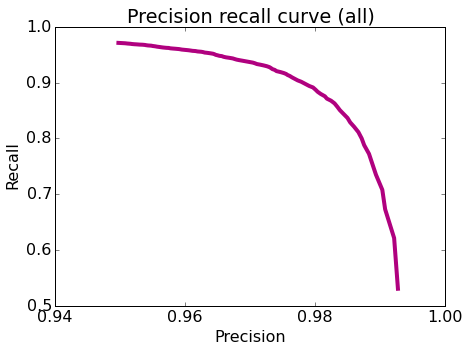

In [55]:
plot_pr_curve(precision_all[:-1], recall_all[:-1], 'Precision recall curve (all)')

## Quiz Question: Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [62]:
temp = filter(lambda s: s['Precision'] > 0.965, full)
temp = reduce(lambda a,b : a if a['threshold'] < b['threshold'] else b, temp)
print temp

{'threshold': 0.70707070707070707, 'Recall': 0.9490300765260723, 'Precision': 0.96500180962721693}


## Quiz Question: Using threshold = 0.98, how many false negatives do we get on the test_data? This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.



In [63]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=apply_threshold(probabilities, 0.98),
                        labels=logit.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(logit.classes_):
    for j, predicted_label in enumerate(logit.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5047
     -1       |        1        |   194
      1       |       -1        |  8250
      1       |        1        | 19845


194

## Precision-Recall on all baby related items



In [65]:
baby_reviews = test_data[test_data['name'].map(lambda x: 'baby' in str(x).lower())]

In [66]:
baby_reviews.head()

,index,name,review,rating,review_clean,sentiment
0,9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
1,10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1
9,56,Baby's First Year Undated Wall Calendar with S...,I searched high and low for a first year calen...,5,I searched high and low for a first year calen...,1
10,59,Our Baby Girl Memory Book,Absolutely love it and all of the Scripture in...,5,Absolutely love it and all of the Scripture in...,1
13,112,Newborn Baby Tracker&reg; - Round the Clock Ch...,This is the best way to keep track of when you...,5,This is the best way to keep track of when you...,1


In [68]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = logit.predict_proba(baby_matrix)[:,1]

In [69]:
threshold_values = np.linspace(0.5, 1, num=100)

In [70]:
precision_all = []
recall_all = []
full = []
for t in threshold_values:
    classes = apply_threshold(probabilities, t)
    ans = prec_recall(classes, baby_reviews['sentiment'])
    precision_all.append(ans['Precision'])
    recall_all.append(ans['Recall'])
    ans['threshold'] = t
    full.append(ans)

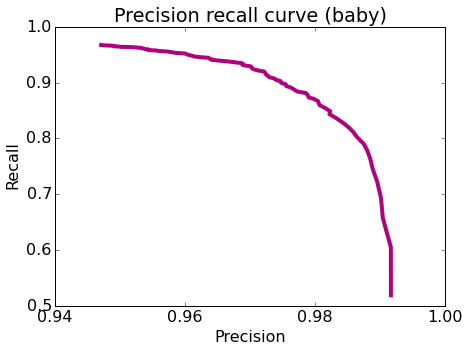

In [72]:
plot_pr_curve(precision_all[:-1], recall_all[:-1], 'Precision recall curve (baby)')

## Quiz Question: Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better for the reviews of data in baby_reviews? Round your answer to 3 decimal places.



In [73]:
temp = filter(lambda s: s['Precision'] > 0.965, full)
temp = reduce(lambda a,b : a if a['threshold'] < b['threshold'] else b, temp)
print temp

{'threshold': 0.73232323232323238, 'Recall': 0.93910198145791679, 'Precision': 0.96560747663551405}


0.732

## Quiz Question: Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

Larger